In [1]:
import pyprob
from pyprob import Model
from pyprob.distributions import Normal
from pyprob.distributions import Uniform
from pyprob.distributions import Categorical

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();

<Figure size 432x288 with 0 Axes>

In [2]:
def plotDist(dist, min_vals=-10, max_vals=10, step_size=0.02, label=None, **kwargs):
    xvals = np.arange(min_vals, max_vals, step_size)
    plt.plot(xvals, [torch.exp(dist.log_prob(x)) for x in xvals], label=label, **kwargs)


def density(dist, x, M=1):
    return M*torch.exp(dist.log_prob(x)).item()


def computeGamma(dist, r, min_vals=-20, max_vals=-20, step_width=0.01):
    x_vals = torch.arange(-20, 20, step_width)
    gamma = torch.sum(torch.exp(dist.log_prob(x_vals)) * (1 - r(x_vals))) * step_width
    return gamma


def computeC(dist, r, min_vals=-20, max_vals=-20, step_width=0.01):
    x_vals = torch.arange(-20, 20, step_width)
    #c = torch.sum(torch.exp(dist.log_prob(x_vals)) * r(x_vals)) * step_width
    c = 0
    for x in x_vals:
        c += torch.exp(dist.log_prob(x)) * r(x) * step_width
    return c

        
class CorrectDistributions:
    def __init__(self, model):
        self.prior_mean = model.prior_mean
        self.prior_std = model.prior_std
        self.likelihood_std = model.likelihood_std
        self.prior_dist = Normal(self.prior_mean, self.prior_std)
        
    @property
    def observed_list(self):
        return self.__observed_list

    @observed_list.setter
    def observed_list(self, new_observed_list):
        self.__observed_list = new_observed_list
        self.construct_correct_posterior()
    
    def construct_correct_posterior(self):
        n = len(self.observed_list)
        posterior_var = 1/(n/self.likelihood_std**2 + 1/self.prior_std**2)
        posterior_mu = posterior_var * (self.prior_mean/self.prior_std**2 + n*np.mean(self.observed_list)/self.likelihood_std**2)
        self.posterior_dist = Normal(posterior_mu, math.sqrt(posterior_var))

    def prior_pdf(self, model, x):
        p = Normal(model.prior_mean,model.prior_stdd)
        return math.exp(p.log_prob(x))

    def plot_posterior(self, min_val, max_val):
        if not hasattr(self, 'posterior_dist'):
            raise AttributeError('observed values are not set yet, and posterior is not defined.')
        plot_function(min_val, max_val, get_dist_pdf(self.posterior_dist), label='correct posterior', color='orange')


    def plot_prior(self, min_val, max_val):
        plot_function(min_val, max_val, get_dist_pdf(self.prior_dist), label='prior', color='green')

In [3]:
def marsaglia(mean, stddev):
        uniform = Uniform(-1, 1)
        s = 1
        while float(s) >= 1:
            x = pyprob.sample(uniform, replace=True)
            y = pyprob.sample(uniform, replace=True)
            s = x*x + y*y
        return mean + stddev * (x * torch.sqrt(-2 * torch.log(s) / s))

class GaussianUnknownMean(Model):
    def __init__(self):
        super().__init__(name='Gaussian with unknown mean')
        self.prior_mean = 0
        self.prior_std = 1
        self.likelihood_std = math.sqrt(0.2)
        self.dist_pi = Normal(self.prior_mean, self.prior_std)
    
    def rejectionSampling(self):
        u = pyprob.sample(Uniform(0, 1))
        if u > 0.5:
            while True:
                #x = marsaglia(self.prior_mean, self.prior_std*2)
                x = pyprob.sample(Normal(self.prior_mean, self.prior_std*4), replace=True)
                u2 = pyprob.sample(Uniform(0, 1), control=False)
                if x < 0 and u2 < 1/4 * torch.exp(Normal(self.prior_mean, self.prior_std).log_prob(x) - Normal(self.prior_mean, self.prior_std*4).log_prob(x)):
                    return x
        else:
            while True:
                x = pyprob.sample(Normal(self.prior_mean, self.prior_std), replace=True)
                if x >= 0:
                    return x

    def forward(self, importance=False, obs=None, exhaustive=False):
        # mu ~ N(0, 1), involving skewed rejection sampling loops
        mu = self.rejectionSampling()

        likelihood = Normal(mu, self.likelihood_std)
        
        pyprob.observe(likelihood, name='obs0')

        return mu
    
model = GaussianUnknownMean()
correct_dists = CorrectDistributions(model)
correct_dists.observed_list = [0]

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 1000/1000 | 467.73       


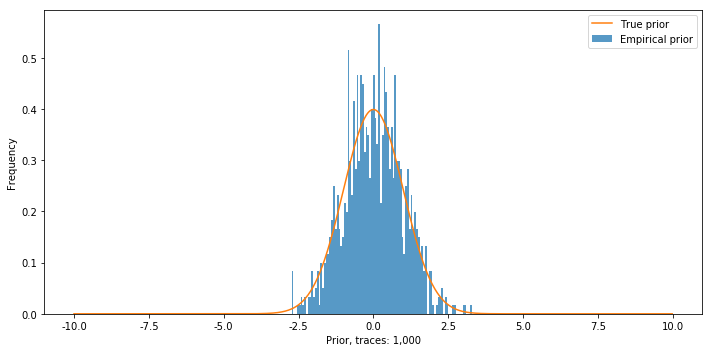

In [4]:
samples = model.prior_distribution(num_traces=1000)
min_vals = min(-10, min(samples))
max_vals = max(10, max(samples))
samples.plot_histogram(show=False, alpha=0.75, label='Empirical prior', bins=100)
plotDist(model.dist_pi, min_vals=min_vals, max_vals=max_vals, label='True prior')

plt.legend();

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 1000/1000 | 481.22       


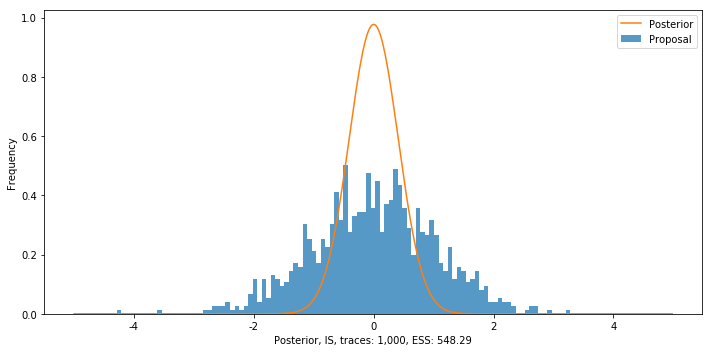

In [5]:
samples = model.posterior_distribution(
                                         num_traces=1000,
                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING,
                                         observe={'obs0': correct_dists.observed_list[0]}
                                         )
min_vals = min(-5, min(samples))
max_vals = max(5, max(samples))
samples.unweighted().plot_histogram(show=False, alpha=0.75, label='Proposal', bins=100)
plotDist(correct_dists.posterior_dist, min_vals=min_vals, max_vals=max_vals, label='Posterior')
plt.legend();

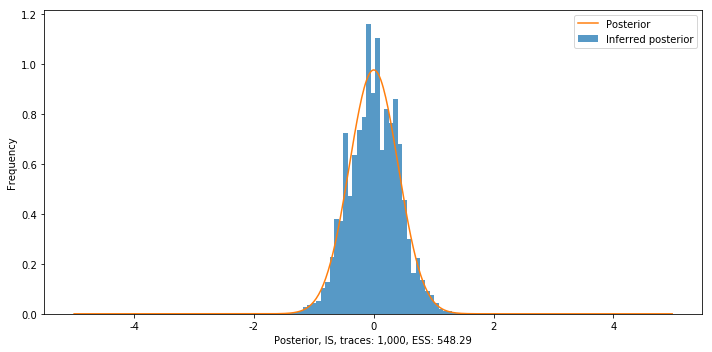

In [6]:
min_vals = min(-5, min(samples))
max_vals = max(5, max(samples))
samples.plot_histogram(show=False, alpha=0.75, label='Inferred posterior', bins=100)
plotDist(correct_dists.posterior_dist, min_vals=min_vals, max_vals=max_vals, label='Posterior')
plt.legend();

In [7]:
model.learn_inference_network(num_traces=1000,
                              observe_embeddings={'obs0' : {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable obs0: reshape not specified, using shape torch.Size([]).
Observable obs0: using embedding dim torch.Size([32]).
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0: embedding depth not specified, using the default 2.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 12__forward__rejectionSampling__u__Uniform__1, distribution: Uniform
New layers, address: 50__forward__rejectionSampling__x__Normal__replace..., distribution: Normal
New layers, address: 172__forward__rejectionSampling__x__Normal__replac..., distribution: Normal
Total addresses: 3, distribution types: 2, parameters: 1,865,781
0d:00:00:03 | 1    | 960       | +2.02e+00 | +8.56e-01 | +9.92e-01 | 0d:00:00:01 | +1.00e-03 | 203.9                               
Stop condition reached. num_traces: 1000
0d:00:00:04 | 1    | 1,024     | 

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 1000/1000 | 97.09       


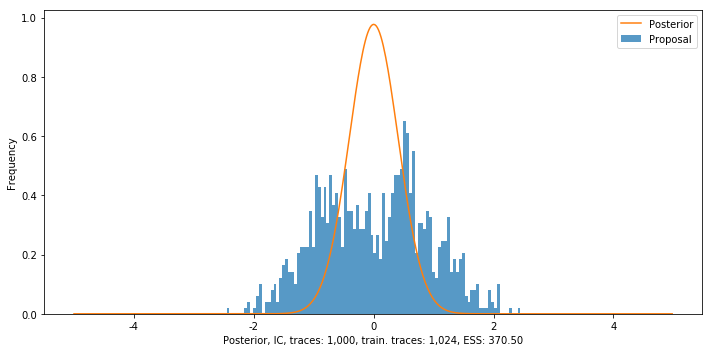

In [8]:
samples = model.posterior_distribution(num_traces=1000,
                                       inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
                                       observe={'obs0': correct_dists.observed_list[0]})
min_vals = min(-5, min(samples))
max_vals = max(5, max(samples))
samples.unweighted().plot_histogram(show=False, alpha=0.75, label='Proposal', bins=100)
plotDist(correct_dists.posterior_dist, min_vals=min_vals, max_vals=max_vals, label='Posterior')
plt.legend();

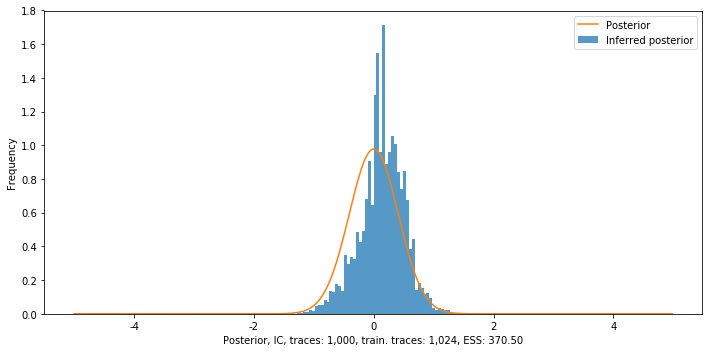

In [9]:
min_vals = min(-5, min(samples))
max_vals = max(5, max(samples))
samples.plot_histogram(show=False, alpha=0.75, label='Inferred posterior', bins=100)
plotDist(correct_dists.posterior_dist, min_vals=min_vals, max_vals=max_vals, label='Posterior')
plt.legend();